In [90]:
import pandas as pd
import numpy as np
import openpyxl
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
raw_data = pd.read_csv("manaus.csv", sep=";", low_memory=False)
raw_data.head()

,_dt_evolucao,_dt_notificacao,_dt_sintomas,_classificacao,_conclusao,_origem,_comorb_cardio,_comorb_cromossomica,_comorb_diabetes,_comorb_hemato,...,_sintoma_tosse,_sintoma_outros,_srag,_teste_anticorpo,_teste_antigeno,_teste_pcr,_bairro,_bairro_mapa,_distrito,_taxa
0,25/01/2020 00:00,03/01/2020 00:00,01/01/2020 00:00,Descartado,Recuperado,"SIVEP,",NaN,NaN,NaN,NaN,...,Sim,Sim,SRAG não especificado,NaN,NaN,NaN,TARUMA,TARUMÃ,OESTE,"0,243042897"
1,03/01/2020 00:00,03/01/2020 00:00,01/01/2020 00:00,Descartado,Óbito,"SIVEP,",NaN,NaN,NaN,NaN,...,Sim,Sim,Influenza B,NaN,NaN,NaN,TARUMA-ACU,TARUMÃ-AÇÚ,OESTE,"0,684931507"
2,05/01/2020 00:00,03/01/2020 00:00,03/01/2020 00:00,Descartado,Óbito,"SIVEP,",NaN,NaN,NaN,NaN,...,Sim,Sim,SRAG não especificado,NaN,NaN,NaN,JORGE TEIXEIRA,JORGE TEIXEIRA,LESTE,"0,073137374"
3,16/01/2020 00:00,08/01/2020 00:00,04/01/2020 00:00,Descartado,Óbito,"SIVEP,",NaN,NaN,NaN,NaN,...,Sim,Sim,SRAG não especificado,NaN,NaN,NaN,FLORES,FLORES,SUL,"0,198306463"
4,11/01/2020 00:00,08/01/2020 00:00,05/01/2020 00:00,Descartado,Recuperado,"SIVEP,",NaN,NaN,NaN,NaN,...,Sim,Sim,SRAG não especificado,NaN,NaN,NaN,CIDADE DE DEUS,CIDADE DE DEUS,NORTE,"0,117699678"


In [92]:
df_confirmed = raw_data[raw_data['_classificacao'] == 'Confirmado']


## 2.1-1.Quantos atributos descrevem cada exemplo? Quais são eles?

In [93]:
quantity_attributes = df_confirmed.shape[1]
print(f'Dataframe possui {quantity_attributes} atributos.')

Dataframe possui 39 atributos.


In [94]:
print(f'Lista de atributos que descrevem cada exemplo, sendo eles:')
attributes = []
for att in df_confirmed.columns.to_numpy():
    attributes.append(att)

Lista de atributos que descrevem cada exemplo, sendo eles:


## 2.1-2.Quantos casos confirmados há em Manaus, cumulativamente?

In [95]:
confirmed_cases = df_confirmed.shape[0]
print(f'{confirmed_cases} casos confirmados em Manaus.')

80420 casos confirmados em Manaus.


## 2.1-3.A qual período de tempo a base de dados se refere, isto é, qual o registro mais antigo e qual o mais recente? Leve em conta a data de notificação.

In [96]:
df_confirmed['_dt_notificacao'] = pd.to_datetime(df_confirmed['_dt_notificacao'], format='%d/%m/%Y %H:%M')
array_dates = np.sort(df_confirmed['_dt_notificacao'].dropna().dt.strftime('%m/%d/%Y'))
first_date = pd.to_datetime(array_dates[0]).strftime("%d/%m/%y")
last_date = pd.to_datetime(array_dates[-1]).strftime("%d/%m/%y")

C:\Users\LudusLab\AppData\Local\Temp/ipykernel_2812/3531587872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_confirmed['_dt_notificacao'] = pd.to_datetime(df_confirmed['_dt_notificacao'], format='%d/%m/%Y %H:%M')


In [97]:
print(f'Registro mais antigo é {first_date}')
print(f'Registro mais recente é {last_date}')

Registro mais antigo é 16/02/20
Registro mais recente é 29/12/20


## Limpeza dos Dados

### Excluir atributos não relevantes

In [98]:
discarded_data = []
def clear_data():
    for att in attributes:
        if att != '_dt_notificacao' and att != '_classificacao' and att != '_conclusao' and att != '_criterio' and att != '_evolução' and att != '_idade' and att != '_faixa etária' and att != '_sexo' and att != '_teste_anticorpo' and att != '_teste_antigeno' and att != '_teste_pcr' and att != '_bairro' and att != '_taxa':
                discarded_data.append(att)

clear_data()

In [99]:
df_confirmed = df_confirmed.drop(discarded_data,axis=1)

### Excluir linhas de dados faltantes

### !O valor zero foi atribuído nas colunas dos testes que o paciente não realizou.!

In [100]:
df_confirmed['_teste_anticorpo'] = df_confirmed['_teste_anticorpo'].fillna(0)
df_confirmed['_teste_antigeno'] = df_confirmed['_teste_antigeno'].fillna(0)
df_confirmed['_teste_pcr']= df_confirmed['_teste_pcr'].fillna(0)

In [101]:
df_clean_data = df_confirmed.dropna()

## 1. Quantos exemplos e atributos há na base de dados após a limpeza e organização?

In [102]:
remaining_data = df_clean_data.shape[0]
print(f'A base de dados restante possui {remaining_data} registros.')

A base de dados restante possui 7645 registros.


In [103]:
remaining_data_att = df_clean_data.shape[1]
print(f'A base de dados restante possui {remaining_data_att} atributos.')

A base de dados restante possui 13 atributos.


## 2. Qual a porcentagem de indivíduos recuperados em relação ao todo?

In [104]:
recovered_patients = df_clean_data[df_clean_data['_conclusao'] == 'Recuperado'].shape[0]
total_patients = df_clean_data.shape[0]

In [105]:
percentage_recovered_patients = (recovered_patients/total_patients)*100
percentage_recovered_patients = np.round(percentage_recovered_patients, 3)

In [106]:
print(f'A porcentagem de indivíduos recuperados é de {percentage_recovered_patients}%.')

A porcentagem de indivíduos recuperados é de 58.496%.


## 3. Os casos acometeram mais indivíduos do sexo masculino ou feminino?

In [107]:
count_F = df_clean_data.groupby(['_sexo']).size()['F']
count_M = df_clean_data.groupby(['_sexo']).size()['M']
print(f"Sexo Feminino, com {count_F} casos" if count_F > count_M else f"Sexo Masculino, com {count_M} casos")

Sexo Masculino, com 4408 casos


## 4.1 Qual a média e desvio padrão de idade dos indivíduos que contraíram COVID-19? 

In [108]:
individuals_age_mean = df_clean_data['_idade'].mean()
individuals_age_std = df_clean_data['_idade'].std()

In [109]:
print(f'Média de idades dos indivíduos é {round(individuals_age_mean,2)} anos.')
print(f'O desvio padrão de idades dos indivíduos é {round(individuals_age_std,2)}.')

Média de idades dos indivíduos é 56.29 anos.
O desvio padrão de idades dos indivíduos é 20.84.


## 4.2 Qual o indivíduo mais jovem e o mais idoso a contraírem tal enfermidade?

In [110]:
older_individual = df_clean_data['_idade'].max()
younger_individual = df_clean_data['_idade'].min()

In [111]:
print(f'O indivíduo mais idoso a contrair a enfermidade: {older_individual} anos')
print(f'O indivíduo mais jovem a contrair a enfermidade: {younger_individual} anos')

O indivíduo mais idoso a contrair a enfermidade: 106.0 anos
O indivíduo mais jovem a contrair a enfermidade: 0.0 anos


## 5. Qual o bairro com maior incidência de casos?

In [112]:
neighborhoods = pd.DataFrame(df_clean_data['_bairro'])

### Criei padrões regex para cada letra com acentos(a, e, i, o, u e ç), passei como parâmetro para uma função que busca o padrão desejado e qual deve ser o caractere para substituição, utilizando a compressão de lista para percorrer cada lista gerada a cada letra limpa.

In [113]:
def clear_data(data, pattern, sub):
    pattern_letter = re.compile(pattern)

    result = re.sub(pattern_letter, sub, data, 5)
    return result

In [114]:
raw_neighborhoods = neighborhoods['_bairro']
clear_a = [clear_data(x, r"^[áàâã]$", "a") for x in raw_neighborhoods]
clear_e = [clear_data(x, r"^[éê]$", "e") for x in clear_a]
clear_i = [clear_data(x, r"^[í]$", "i") for x in clear_e]
clear_o = [clear_data(x, r"^[óôòõ]$", "o") for x in clear_i]
clear_u = [clear_data(x, r"^[ú]$", "u") for x in clear_o]
clear_c = [clear_data(x, r"^[ç]$", "c") for x in clear_u]
df_neighborhoods_clean = pd.DataFrame(clear_c, columns = ["_bairro"])

In [115]:
higher_incidence_neighborhood = df_neighborhoods_clean.groupby(by ='_bairro').size().idxmax()

In [116]:
number_cases = df_neighborhoods_clean.groupby(by ='_bairro').size().max()

In [117]:
print (f'O bairro com maior incidência de casos foi {higher_incidence_neighborhood} com {number_cases} casos confirmados.')

O bairro com maior incidência de casos foi CIDADE NOVA com 480 casos confirmados.


## 6 - Quais os três bairros com maior incidência de casos recuperados?

In [118]:
select = df_clean_data._conclusao == 'Recuperado'
recovered = df_clean_data[select]

In [119]:
neighborhood_1 = recovered._bairro.value_counts().index[0]
neighborhood_2 = recovered._bairro.value_counts().index[1]
neighborhood_3 = recovered._bairro.value_counts().index[2]

In [120]:
neighborhood_sum_1 = recovered._bairro.value_counts()[0]
neighborhood_sum_2 = recovered._bairro.value_counts()[1]
neighborhood_sum_3 = recovered._bairro.value_counts()[2]

In [121]:
print(f'Três bairros com maior incidência de casos recuperados são: \n{neighborhood_1} com {neighborhood_sum_1} casos, \n{neighborhood_2} com {neighborhood_sum_2} casos e \n{neighborhood_3} com {neighborhood_sum_3} casos.')

Três bairros com maior incidência de casos recuperados são: 
CIDADE NOVA com 263 casos, 
JORGE TEIXEIRA com 183 casos e 
COMPENSA com 168 casos.


## 7. Quais os tipos de testes efetuados, segundo os dados? Indique os dados de maneira quantitativa e percentual.

In [122]:
print('Foram realizados testes do tipo: anticorpo, antigeno e pcr.')

Foram realizados testes do tipo: anticorpo, antigeno e pcr.


In [123]:
antibody = df_clean_data._teste_anticorpo.sum()

In [124]:
antigen = df_clean_data._teste_antigeno.sum()

In [125]:
pcr = df_clean_data._teste_pcr.sum()

In [126]:
print(f'Quantitativa\nTeste Anticorpo: {antibody},\nTeste Antigeno: {antigen},\nTeste PCR: {pcr}.')

Quantitativa
Teste Anticorpo: 134.0,
Teste Antigeno: 37.0,
Teste PCR: 3849.0.


In [127]:
total_tests = antibody + antigen + pcr

In [128]:
print(f'Percentual\nTeste Anticorpo: {round((antibody/total_tests)*100,2)}%,\nTeste Antigeno: {round((antigen/total_tests)*100,2)}%,\nTeste PCR: {round((pcr/total_tests)*100,2)}%.')

Percentual
Teste Anticorpo: 3.33%,
Teste Antigeno: 0.92%,
Teste PCR: 95.75%.


## 8. Qual taxa de letalidade pode ser calculada a partir do conjunto de dados? Para calcular esta taxa, considere a fração do total de óbitos pelo total de casos

In [129]:
selection = df_clean_data._conclusao == 'Óbito'
death_rates = df_clean_data[selection].shape[0]

In [130]:
lethal_rate = death_rates/df_confirmed.shape[0]
print(f'Taxa de letalidade calculada a partir do conjunto de dados: {round(lethal_rate*100, 2)}%.')

Taxa de letalidade calculada a partir do conjunto de dados: 3.88%.


## 9. Qual o tipo de correlação, mediante coeficiente de correlação de Pearson, entre a idade e o número de casos? Para responder a esta pergunte, agrupe o número de casos por idade e efetue o cálculo de tal coeficiente. Indique, a partir do resultado, a natureza desta correlação, se é positiva ou negativa, e qual sua intensidade.

In [131]:
df_idade = pd.DataFrame(df_clean_data.groupby(by='_idade', as_index=False)[['_idade']].count())
df_idade.rename(columns={'_idade': 'contagem'}, inplace = True)
df_idade.rename_axis('idade')

,contagem
idade,
0,107
1,69
2,35
3,25
4,16
...,...
98,8
99,3
100,1


In [132]:
df_idade['idades'] = df_idade.index
correlacao = df_idade.idades.corr(df_idade.contagem)

In [133]:
print(f'O valor da correlação de Pearson é positiva, de natureza desprezível: {round(correlacao,2)}.')

O valor da correlação de Pearson é positiva, de natureza desprezível: 0.25.


# Visualização de Dados

## 1. Construa um histograma denotando a quantidade de casos nos 10 bairros em que houve mais casos registrados. Inclua todos os bairros remanescentes em uma categoria denominada “Outros.” Denote as informações de maneira percentual;

In [134]:
neighborhoods = df_neighborhoods_clean.groupby(by='_bairro').size().sort_values(ascending=False).head(10)

In [135]:
others = df_neighborhoods_clean.groupby(by='_bairro').size().sort_values(ascending=True).head(137).sum()

In [136]:
neighborhoods_names = [neighborhood for neighborhood in neighborhoods.index]
neighborhoods_names.append('OUTROS')

In [137]:
values = [round((neighborhood/df_neighborhoods_clean.shape[0])*100, 2) for neighborhood in neighborhoods]
values.append(round((others/df_neighborhoods_clean.shape[0])*100, 2))

In [138]:
df_neighborhoods = pd.DataFrame(neighborhoods_names, columns=['bairros'])
df_neighborhoods['percentual'] = values

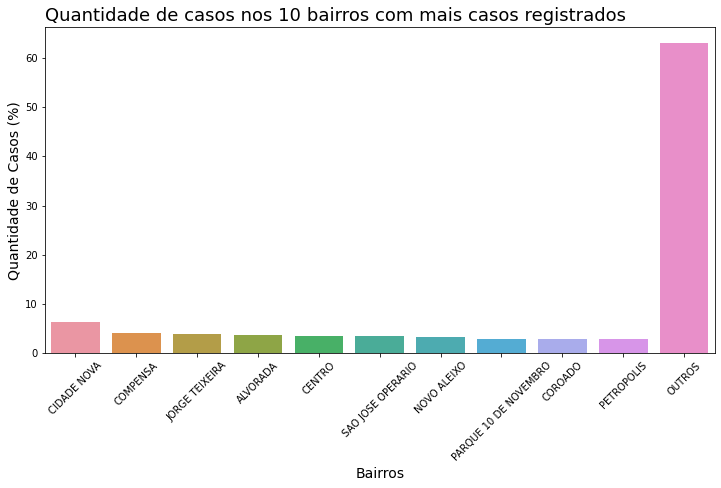

In [155]:
ax = sns.barplot(data=df_neighborhoods, x="bairros", y="percentual")
ax.figure.set_size_inches(12, 6)
ax.set_title('Quantidade de casos nos 10 bairros com mais casos registrados', loc='left', fontsize=18)
ax.set_xlabel('Bairros', fontsize = '14')
ax.set_ylabel('Quantidade de Casos (%)', fontsize = '14')
plt.xticks(rotation=45)
ax = ax

## 2. Denote, por sexo, o boxplot da idade dos casos confirmados. Há outliers?

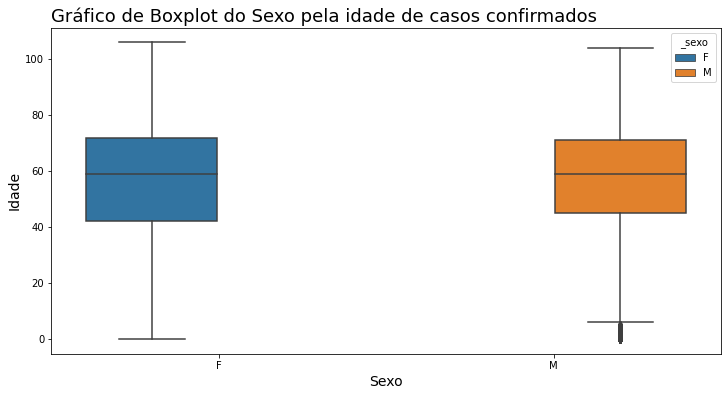

In [151]:
ax = sns.boxplot(x="_sexo", y="_idade", data=df_clean_data, hue="_sexo")
ax.figure.set_size_inches(12, 6)
ax.set_title('Gráfico de Boxplot do Sexo pela idade de casos confirmados', loc='left', fontsize=18)
ax.set_xlabel('Sexo', fontsize = '14')
ax.set_ylabel('Idade', fontsize = '14')
ax = ax

### Segundo análise do gráfico de Boxplot, sim, existem outliers no dados do sexo masculino.

## 3. Denote em um gráfico de barras o número de novos casos por dia, considerando os 10 últimos dias existentes na base de dados;

In [379]:
x = slice(-1, -11, -1)

In [380]:
df_new_cases = pd.DataFrame(df_clean_data.groupby('_dt_notificacao').size()[x], columns=['novos_casos'])

In [381]:
df_new_cases['datas'] = df_new_cases.index.strftime("%d/%m/%y")

In [384]:
df_new_cases = df_new_cases.sort_values(by='datas', ascending=True)

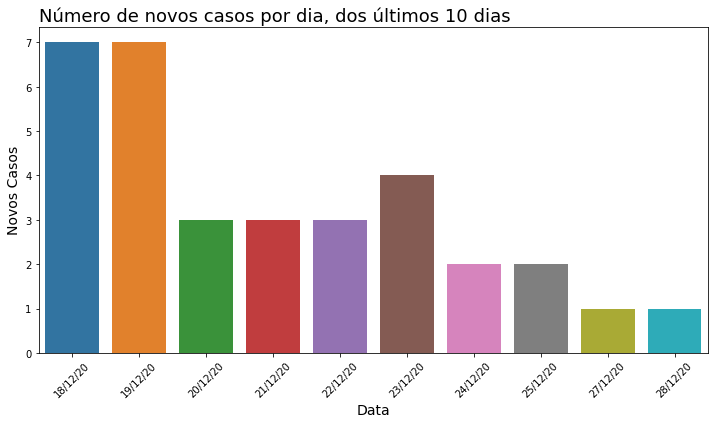

In [385]:
ax = sns.barplot(x="datas", y="novos_casos", data=df_new_cases)
ax.figure.set_size_inches(12, 6)
ax.set_title('Número de novos casos por dia, dos últimos 10 dias', loc='left', fontsize=18)
ax.set_xlabel('Data', fontsize = '14')
ax.set_ylabel('Novos Casos', fontsize = '14')
plt.xticks(rotation=45)
ax = ax

## 4. Repita o gráfico anterior considerando o número de casos recuperados;

In [392]:
df_recovered = pd.DataFrame(df_clean_data[df_clean_data['_conclusao'] == 'Recuperado'].groupby('_dt_notificacao').size()[x], columns=['recuperados'])

In [393]:
df_recovered['datas'] = df_recovered.index.strftime("%d/%m/%y")

In [394]:
df_recovered = df_recovered.sort_values(by='datas', ascending=True)

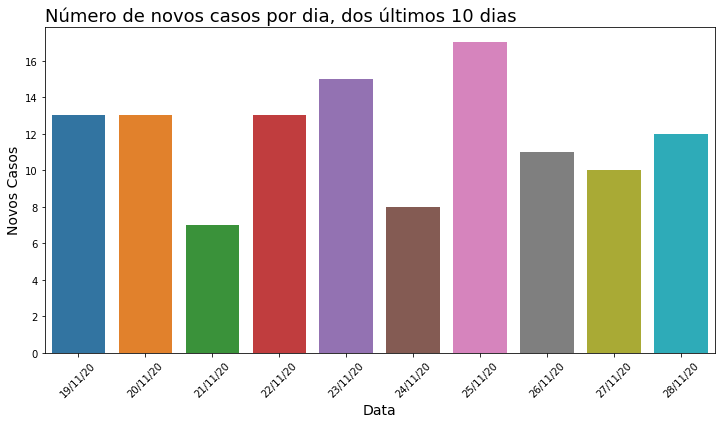

In [395]:
ax = sns.barplot(x="datas", y="recuperados", data=df_recovered)
ax.figure.set_size_inches(12, 6)
ax.set_title('Número de novos casos por dia, dos últimos 10 dias', loc='left', fontsize=18)
ax.set_xlabel('Data', fontsize = '14')
ax.set_ylabel('Novos Casos', fontsize = '14')
plt.xticks(rotation=45)
ax = ax

## 5. Construa um histograma que denote a quantidade percentual de casos por grupo etário, considerando que cada grupo contempla uma década (0 a 10 anos, 11 a 20 anos, etc.);

In [398]:
df_clean_data.rename(columns={"_faixa etária": "_faixa_etaria"}, inplace=True)

In [401]:
df_faixa = df_clean_data.groupby(['_faixa_etaria']).count()

In [402]:
df_faixa.drop(columns=['_dt_notificacao','_conclusao','_criterio','_evolução','_sexo','_teste_anticorpo','_teste_antigeno','_teste_pcr','_bairro','_taxa'], inplace=True)

In [410]:
df_faixa._idade = round(df_faixa._idade/df_clean_data.shape[0],2)

In [411]:
df_faixa['_faixa_etaria'] = df_faixa.index

In [412]:
df_faixa

,_classificacao,_idade,_faixa_etaria
_faixa_etaria,,,
1a - 4a,145,0.00,1a - 4a
5a - 9a,71,0.00,5a - 9a
< 1a,107,0.00,< 1a
10a - 14a,76,0.00,10a - 14a
15a - 19a,71,0.00,15a - 19a
20a - 29a,316,0.00,20a - 29a
30a - 39a,696,0.01,30a - 39a
40a - 49a,1031,0.01,40a - 49a
50a - 59a,1330,0.01,50a - 59a


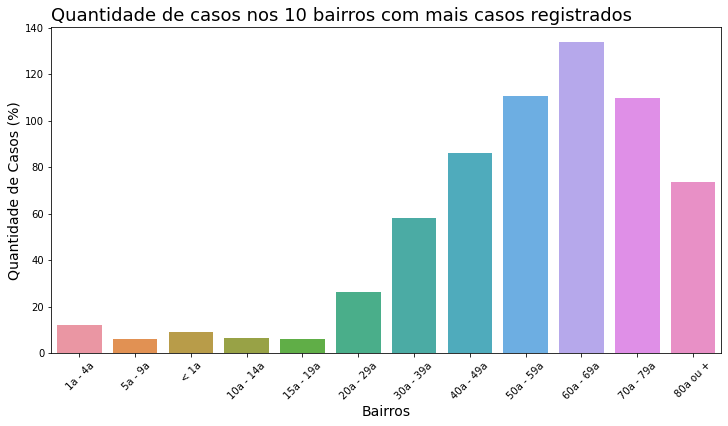

In [408]:
ax = sns.barplot(data=df_faixa, x="_faixa_etaria", y="_idade")
ax.figure.set_size_inches(12, 6)
ax.set_title('Quantidade de casos nos 10 bairros com mais casos registrados', loc='left', fontsize=18)
ax.set_xlabel('Bairros', fontsize = '14')
ax.set_ylabel('Quantidade de Casos (%)', fontsize = '14')
plt.xticks(rotation=45)
ax = ax

## 6. Elabore um gráfico que mostra o cumulativo de casos notificados ao longo do tempo;

In [423]:
df_months = df_clean_data['_dt_notificacao'].dt.strftime('%m/%Y')

In [418]:
df_acc = df_clean_data.groupby('_dt_notificacao').size().cumsum(axis=0)

In [422]:
df_acc

_dt_notificacao
2020-02-23       1
2020-02-28       2
2020-03-02       4
2020-03-11       5
2020-03-16       6
              ... 
2020-12-23    7639
2020-12-24    7641
2020-12-25    7643
2020-12-27    7644
2020-12-28    7645
Length: 288, dtype: int64

In [71]:
df_acc = df_clean_data.groupby('_dt_notificacao').count()

In [72]:
df_acc.drop(columns=['_conclusao','_criterio','_evolução', '_idade','_faixa etária' ,'_sexo','_teste_anticorpo','_teste_antigeno','_teste_pcr','_bairro','_taxa'], inplace=True)

In [73]:
df_acc['casos_acumulativos'] = df_acc['_classificacao'].cumsum(axis=0)

In [74]:
df_acc['_notificacao'] = df_acc.index.get_level_values(0).copy()

In [75]:
df_acc.loc[:, '_notificacao_mes'] = df_acc._notificacao.dt.month

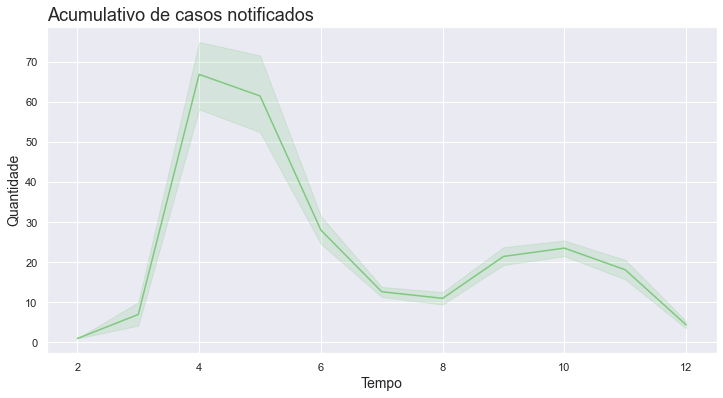

In [76]:
sns.set_palette('Accent')
sns.set_style('darkgrid')
ax = sns.lineplot(x='_notificacao_mes', y='_classificacao', data=df_acc)
ax.figure.set_size_inches(12, 6)
ax.set_title('Acumulativo de casos notificados', loc='left', fontsize=18)
ax.set_xlabel('Tempo', fontsize = '14')
ax.set_ylabel('Quantidade', fontsize = '14')
ax = ax

## 7. Faça um gráfico do tipo scatterplot que denote a idade versus o número total de casos registrado para aquela idade. Aproveite o processamento efetuado para o cálculo da correlação. É possível observar alguma tendência?

In [77]:
df_idadexcasos = df_clean_data.groupby('_idade').count().drop(columns=['_dt_notificacao','_conclusao','_criterio','_evolução','_faixa etária' ,'_sexo','_teste_anticorpo','_teste_antigeno','_teste_pcr','_bairro','_taxa'])

In [78]:
df_idadexcasos.rename(columns={"_classificacao": "idades_agp"}, inplace=True)

In [79]:
df_idadexcasos['idade'] = df_idadexcasos.index.copy()
df_idadexcasos.index = range(df_idadexcasos.shape[0])

<AxesSubplot:xlabel='idade', ylabel='idades_agp'>

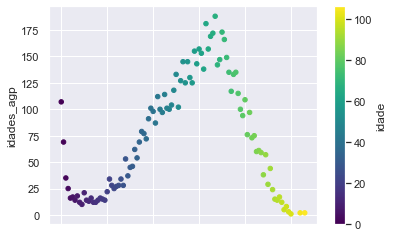

In [80]:
df_idadexcasos.plot.scatter(x='idade', y='idades_agp', c='idade', colormap='viridis')

In [81]:
df_idadexcasos.idade.corr(df_idadexcasos.idades_agp)

0.2409745125222918

### Podemos observar uma tendência clara da doença atingir pessoas com idades próximas a 60 anos.